# MODELO FEDERADO

## IMPORTAR LIBRERÍAS

In [9]:
import os
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import random

## SEMILLA POR REPRODUCIBILIDAD

In [10]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## PREPROCESO DE LOS DATOS

In [11]:
folder_path = r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/TrainTestSplit"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess(files, all_sources):
    df_list = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"])
        df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
        df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))
        df_list.append(df_sampled)
    full_df = pd.concat(df_list, ignore_index=True)
    
    full_df['source'] = pd.Categorical(full_df['source'], categories=all_sources)
    full_df = pd.get_dummies(full_df, columns=['source'], prefix='src', dtype=np.float32)
    
    return full_df

def prepare_data(df, scaler=None):
    X = df.drop(columns=['Pmp (W)']).values.astype(np.float32)
    y = df['Pmp (W)'].values.astype(np.float32)
    if scaler is None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
    X_tensor = torch.tensor(X).to(device)
    y_tensor = torch.tensor(y).unsqueeze(1).to(device)
    return X_tensor, y_tensor, scaler

In [12]:
class EnhancedDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

## DEFINICIÓN DE LOS HIPERPARÁMETROS
En este caso, se simulará un proceso federado de 5 rondas de 40 épocas cada una para cada uno de los clientes. El resto de hiperparámetros son los mismos que en el modelo centralizado

In [13]:
federated_rounds = 5       
local_epochs = 40          
batch_size = 512
lr = 0.0001
weight_decay = 1e-4

## SEPARACIÓN DE LOS DATOS
Se cogen los datos ya separados en el notebook TrainTestSplit

In [14]:
clients = {
    "cocoa": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "cocoa" in f.lower()],
    "eugene": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "eugene" in f.lower()],
    "golden": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "golden" in f.lower()]
}

test_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "test" in f]


## COGER COLUMNA SOURCE DEL ORIGEN ESPECÍFICO

In [15]:
all_sources = set()

for client_files in clients.values():
    for file in client_files:
        file_path = os.path.join(folder_path, file)
        df_temp = pd.read_csv(file_path, usecols=['source'])
        all_sources.update(df_temp['source'].unique())


all_sources = sorted(all_sources) 

In [16]:
temp_df = load_and_preprocess(clients["cocoa"], all_sources)
X_temp, y_temp, scaler = prepare_data(temp_df)  

test_df = load_and_preprocess(test_files, all_sources)

input_dim = X_temp.shape[1]

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))
/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))
/tmp/ipykernel_14833/194159312

## INICIALIZACIÓN DEL MODELO Y CARGA DE PESOS DEL MODELO CENTRALIZADO

In [ ]:
global_model = EnhancedDNN(input_dim).to(device)

#state_dict = torch.load(r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/TrainTestSplit")
#global_model.load_state_dict(state_dict)

global_model.train()

EnhancedDNN(
  (model): Sequential(
    (0): Linear(in_features=42, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

## DEFINICIÓN DE LA FUNCIÓN DE ENTRENAMIENTO

In [18]:
def local_train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        print(f"Local epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return model.state_dict(), len(train_loader.dataset)

## DEFINICIÓN DE LA FUNCIÓN FEDERAGED AVERAGING PARA COMBINAR LOS PESOS DE LOS MODELOS DE CADA CLIENTE

In [19]:
def fed_avg(state_dicts, data_sizes):
    avg_state = copy.deepcopy(state_dicts[0])
    total_samples = sum(data_sizes)

    for key in avg_state.keys():
        if avg_state[key].dtype in [torch.int64, torch.long]:
            avg_state[key] = state_dicts[0][key].clone()
        else:
            avg_state[key] = torch.zeros_like(avg_state[key], dtype=torch.float32)

            for state, size in zip(state_dicts, data_sizes):
                weight = size / total_samples
                avg_state[key] += state[key].float() * weight

    return avg_state

## ENTRENAMIENTO DE CADA CLIENTE Y ACTUALIZACIÓN DEL MODELO GLOBAL

In [20]:
criterion = nn.MSELoss()
best_test_loss = np.inf
best_federated_model_path = "best_federated_model.pth"

print("=== Iniciando entrenamiento federado ===")
for round in range(1, federated_rounds+1):
    print(f"\n--- Ronda Federada {round} ---")
    local_state_dicts = []
    data_sizes = []
    for client_name, files in clients.items():
        print(f"Entrenando cliente: {client_name}")
        client_df = load_and_preprocess(files, all_sources)
        X_local, y_local, _ = prepare_data(client_df, scaler)
        local_dataset = TensorDataset(X_local, y_local)
        local_loader = DataLoader(local_dataset, batch_size=batch_size, shuffle=True)
        
        local_model = copy.deepcopy(global_model)
        optimizer_local = optim.Adam(local_model.parameters(), lr=lr, weight_decay=weight_decay)
        
        local_state, n_samples = local_train(local_model, local_loader, criterion, optimizer_local, local_epochs)
        local_state_dicts.append(local_state)
        data_sizes.append(n_samples)
    
    global_state = fed_avg(local_state_dicts, data_sizes)
    global_model.load_state_dict(global_state)
    print(f"Ronda {round} completada. Se han promediado los pesos de {len(clients)} clientes.")
    
    X_test_tensor, y_test_tensor, _ = prepare_data(test_df, scaler)
    global_model.eval()
    with torch.no_grad():
        y_pred = global_model(X_test_tensor).cpu().numpy()
        y_test_np = y_test_tensor.cpu().numpy()
        test_loss = mean_squared_error(y_test_np, y_pred)
        print(f"Test MSE después de ronda {round}: {test_loss:.4f}")
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(global_model.state_dict(), best_federated_model_path)
        print(f"Nuevo mejor modelo federado guardado: {best_federated_model_path}")



=== Iniciando entrenamiento federado ===

--- Ronda Federada 1 ---
Entrenando cliente: cocoa


/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 1671.4203
Local epoch 2, Loss: 90.5187
Local epoch 3, Loss: 57.2548
Local epoch 4, Loss: 49.9725
Local epoch 5, Loss: 45.4437
Local epoch 6, Loss: 42.3940
Local epoch 7, Loss: 41.3286
Local epoch 8, Loss: 38.7537
Local epoch 9, Loss: 37.8121
Local epoch 10, Loss: 35.2536
Local epoch 11, Loss: 35.3497
Local epoch 12, Loss: 33.5889
Local epoch 13, Loss: 32.8220
Local epoch 14, Loss: 32.0665
Local epoch 15, Loss: 32.7658
Local epoch 16, Loss: 30.9312
Local epoch 17, Loss: 30.8077
Local epoch 18, Loss: 29.7028
Local epoch 19, Loss: 29.7520
Local epoch 20, Loss: 29.3604
Local epoch 21, Loss: 28.6650
Local epoch 22, Loss: 28.8726
Local epoch 23, Loss: 27.2380
Local epoch 24, Loss: 28.2740
Local epoch 25, Loss: 27.8466
Local epoch 26, Loss: 27.1739
Local epoch 27, Loss: 26.9876
Local epoch 28, Loss: 26.0994
Local epoch 29, Loss: 26.6307
Local epoch 30, Loss: 26.1840
Local epoch 31, Loss: 26.1541
Local epoch 32, Loss: 25.2873
Local epoch 33, Loss: 26.0594
Local epoch 34, L

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 1120.7485
Local epoch 2, Loss: 84.9088
Local epoch 3, Loss: 62.1379
Local epoch 4, Loss: 52.4255
Local epoch 5, Loss: 45.9309
Local epoch 6, Loss: 42.1570
Local epoch 7, Loss: 37.8286
Local epoch 8, Loss: 35.7797
Local epoch 9, Loss: 33.1633
Local epoch 10, Loss: 33.4098
Local epoch 11, Loss: 30.0396
Local epoch 12, Loss: 29.8570
Local epoch 13, Loss: 29.3942
Local epoch 14, Loss: 28.4180
Local epoch 15, Loss: 27.6575
Local epoch 16, Loss: 26.8807
Local epoch 17, Loss: 25.6334
Local epoch 18, Loss: 25.7196
Local epoch 19, Loss: 25.7514
Local epoch 20, Loss: 24.3822
Local epoch 21, Loss: 23.7208
Local epoch 22, Loss: 23.4804
Local epoch 23, Loss: 24.1210
Local epoch 24, Loss: 22.3770
Local epoch 25, Loss: 23.1694
Local epoch 26, Loss: 22.4201
Local epoch 27, Loss: 22.0764
Local epoch 28, Loss: 22.2984
Local epoch 29, Loss: 21.1423
Local epoch 30, Loss: 21.3046
Local epoch 31, Loss: 21.2510
Local epoch 32, Loss: 21.4230
Local epoch 33, Loss: 20.7592
Local epoch 34, L

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 3291.3043
Local epoch 2, Loss: 2994.8697
Local epoch 3, Loss: 2092.0876
Local epoch 4, Loss: 842.1536
Local epoch 5, Loss: 249.2225
Local epoch 6, Loss: 153.7716
Local epoch 7, Loss: 127.9928
Local epoch 8, Loss: 112.2954
Local epoch 9, Loss: 101.4054
Local epoch 10, Loss: 95.3917
Local epoch 11, Loss: 91.9252
Local epoch 12, Loss: 87.4367
Local epoch 13, Loss: 80.5477
Local epoch 14, Loss: 76.8457
Local epoch 15, Loss: 74.1594
Local epoch 16, Loss: 73.2275
Local epoch 17, Loss: 70.4003
Local epoch 18, Loss: 69.7334
Local epoch 19, Loss: 66.1507
Local epoch 20, Loss: 63.4026
Local epoch 21, Loss: 63.5801
Local epoch 22, Loss: 61.2622
Local epoch 23, Loss: 59.8805
Local epoch 24, Loss: 59.3439
Local epoch 25, Loss: 56.8516
Local epoch 26, Loss: 56.8842
Local epoch 27, Loss: 57.2239
Local epoch 28, Loss: 55.3807
Local epoch 29, Loss: 51.8792
Local epoch 30, Loss: 53.5962
Local epoch 31, Loss: 49.8403
Local epoch 32, Loss: 49.6739
Local epoch 33, Loss: 50.6531
Local e

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 48.7763
Local epoch 2, Loss: 29.9600
Local epoch 3, Loss: 28.4060
Local epoch 4, Loss: 26.4358
Local epoch 5, Loss: 26.6009
Local epoch 6, Loss: 25.8250
Local epoch 7, Loss: 25.3331
Local epoch 8, Loss: 24.2384
Local epoch 9, Loss: 24.4216
Local epoch 10, Loss: 23.4098
Local epoch 11, Loss: 24.1388
Local epoch 12, Loss: 23.9425
Local epoch 13, Loss: 23.4677
Local epoch 14, Loss: 23.3597
Local epoch 15, Loss: 22.9317
Local epoch 16, Loss: 22.2484
Local epoch 17, Loss: 22.2236
Local epoch 18, Loss: 22.2280
Local epoch 19, Loss: 22.3876
Local epoch 20, Loss: 22.5258
Local epoch 21, Loss: 23.0866
Local epoch 22, Loss: 22.6372
Local epoch 23, Loss: 21.7584
Local epoch 24, Loss: 21.7748
Local epoch 25, Loss: 21.2596
Local epoch 26, Loss: 21.3636
Local epoch 27, Loss: 20.9184
Local epoch 28, Loss: 20.1773
Local epoch 29, Loss: 19.7417
Local epoch 30, Loss: 20.0187
Local epoch 31, Loss: 20.7945
Local epoch 32, Loss: 20.2842
Local epoch 33, Loss: 20.2191
Local epoch 34, Los

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 58.2619
Local epoch 2, Loss: 30.3747
Local epoch 3, Loss: 26.5814
Local epoch 4, Loss: 24.5382
Local epoch 5, Loss: 23.0546
Local epoch 6, Loss: 22.9056
Local epoch 7, Loss: 21.6230
Local epoch 8, Loss: 21.0164
Local epoch 9, Loss: 20.9779
Local epoch 10, Loss: 20.0939
Local epoch 11, Loss: 19.6361
Local epoch 12, Loss: 19.8119
Local epoch 13, Loss: 20.0892
Local epoch 14, Loss: 19.6253
Local epoch 15, Loss: 19.1315
Local epoch 16, Loss: 18.6870
Local epoch 17, Loss: 18.6829
Local epoch 18, Loss: 18.1062
Local epoch 19, Loss: 18.9086
Local epoch 20, Loss: 17.1468
Local epoch 21, Loss: 17.5537
Local epoch 22, Loss: 17.1051
Local epoch 23, Loss: 17.4124
Local epoch 24, Loss: 17.0366
Local epoch 25, Loss: 16.7880
Local epoch 26, Loss: 16.4624
Local epoch 27, Loss: 16.3915
Local epoch 28, Loss: 16.0424
Local epoch 29, Loss: 16.6708
Local epoch 30, Loss: 16.0003
Local epoch 31, Loss: 15.8545
Local epoch 32, Loss: 15.6039
Local epoch 33, Loss: 15.3343
Local epoch 34, Los

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 815.1338
Local epoch 2, Loss: 610.7247
Local epoch 3, Loss: 363.9603
Local epoch 4, Loss: 204.0036
Local epoch 5, Loss: 146.6537
Local epoch 6, Loss: 124.4435
Local epoch 7, Loss: 100.8688
Local epoch 8, Loss: 88.4160
Local epoch 9, Loss: 84.2831
Local epoch 10, Loss: 76.3224
Local epoch 11, Loss: 72.6178
Local epoch 12, Loss: 69.6981
Local epoch 13, Loss: 65.2257
Local epoch 14, Loss: 65.8713
Local epoch 15, Loss: 61.2983
Local epoch 16, Loss: 58.3656
Local epoch 17, Loss: 56.1342
Local epoch 18, Loss: 57.2658
Local epoch 19, Loss: 53.8558
Local epoch 20, Loss: 52.3233
Local epoch 21, Loss: 49.8795
Local epoch 22, Loss: 50.8535
Local epoch 23, Loss: 47.1923
Local epoch 24, Loss: 47.7408
Local epoch 25, Loss: 45.4153
Local epoch 26, Loss: 47.0465
Local epoch 27, Loss: 45.4062
Local epoch 28, Loss: 44.1960
Local epoch 29, Loss: 43.8123
Local epoch 30, Loss: 43.3265
Local epoch 31, Loss: 41.9234
Local epoch 32, Loss: 42.9316
Local epoch 33, Loss: 39.3447
Local epoch 

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 37.0233
Local epoch 2, Loss: 24.4855
Local epoch 3, Loss: 22.3165
Local epoch 4, Loss: 22.3353
Local epoch 5, Loss: 21.4076
Local epoch 6, Loss: 20.0770
Local epoch 7, Loss: 20.3313
Local epoch 8, Loss: 20.6015
Local epoch 9, Loss: 20.4146
Local epoch 10, Loss: 19.8049
Local epoch 11, Loss: 19.6822
Local epoch 12, Loss: 19.4016
Local epoch 13, Loss: 19.0071
Local epoch 14, Loss: 18.7937
Local epoch 15, Loss: 18.4051
Local epoch 16, Loss: 18.2998
Local epoch 17, Loss: 18.8003
Local epoch 18, Loss: 18.0051
Local epoch 19, Loss: 18.2140
Local epoch 20, Loss: 18.2129
Local epoch 21, Loss: 17.8725
Local epoch 22, Loss: 17.9883
Local epoch 23, Loss: 17.5492
Local epoch 24, Loss: 18.0633
Local epoch 25, Loss: 17.8905
Local epoch 26, Loss: 17.4248
Local epoch 27, Loss: 16.9338
Local epoch 28, Loss: 17.4008
Local epoch 29, Loss: 17.0323
Local epoch 30, Loss: 16.8778
Local epoch 31, Loss: 17.2094
Local epoch 32, Loss: 17.1651
Local epoch 33, Loss: 16.2574
Local epoch 34, Los

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 39.3785
Local epoch 2, Loss: 21.6315
Local epoch 3, Loss: 20.3126
Local epoch 4, Loss: 18.3982
Local epoch 5, Loss: 17.4500
Local epoch 6, Loss: 17.4162
Local epoch 7, Loss: 17.2009
Local epoch 8, Loss: 16.2530
Local epoch 9, Loss: 16.5063
Local epoch 10, Loss: 15.6330
Local epoch 11, Loss: 15.8756
Local epoch 12, Loss: 15.5658
Local epoch 13, Loss: 16.0204
Local epoch 14, Loss: 15.2405
Local epoch 15, Loss: 15.4141
Local epoch 16, Loss: 15.4163
Local epoch 17, Loss: 14.3232
Local epoch 18, Loss: 14.6642
Local epoch 19, Loss: 13.8345
Local epoch 20, Loss: 14.4511
Local epoch 21, Loss: 13.9492
Local epoch 22, Loss: 13.9569
Local epoch 23, Loss: 14.0663
Local epoch 24, Loss: 13.5836
Local epoch 25, Loss: 14.0501
Local epoch 26, Loss: 13.3752
Local epoch 27, Loss: 13.7880
Local epoch 28, Loss: 13.6094
Local epoch 29, Loss: 13.2770
Local epoch 30, Loss: 13.2489
Local epoch 31, Loss: 12.8558
Local epoch 32, Loss: 13.0554
Local epoch 33, Loss: 12.9776
Local epoch 34, Los

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 730.1372
Local epoch 2, Loss: 415.8934
Local epoch 3, Loss: 201.5187
Local epoch 4, Loss: 132.2953
Local epoch 5, Loss: 108.5519
Local epoch 6, Loss: 91.6573
Local epoch 7, Loss: 78.3261
Local epoch 8, Loss: 71.7754
Local epoch 9, Loss: 65.6821
Local epoch 10, Loss: 61.5648
Local epoch 11, Loss: 57.6586
Local epoch 12, Loss: 55.3707
Local epoch 13, Loss: 51.7558
Local epoch 14, Loss: 50.3246
Local epoch 15, Loss: 47.6013
Local epoch 16, Loss: 45.9619
Local epoch 17, Loss: 44.1455
Local epoch 18, Loss: 42.0436
Local epoch 19, Loss: 42.2624
Local epoch 20, Loss: 41.6015
Local epoch 21, Loss: 41.5492
Local epoch 22, Loss: 39.6703
Local epoch 23, Loss: 37.8594
Local epoch 24, Loss: 37.3728
Local epoch 25, Loss: 36.9870
Local epoch 26, Loss: 35.8279
Local epoch 27, Loss: 37.9936
Local epoch 28, Loss: 34.1652
Local epoch 29, Loss: 35.2244
Local epoch 30, Loss: 34.2646
Local epoch 31, Loss: 34.7163
Local epoch 32, Loss: 32.8579
Local epoch 33, Loss: 31.4942
Local epoch 34

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 30.8589
Local epoch 2, Loss: 20.2599
Local epoch 3, Loss: 19.1061
Local epoch 4, Loss: 18.3392
Local epoch 5, Loss: 17.3755
Local epoch 6, Loss: 17.4784
Local epoch 7, Loss: 17.1187
Local epoch 8, Loss: 17.0781
Local epoch 9, Loss: 17.2068
Local epoch 10, Loss: 16.7464
Local epoch 11, Loss: 16.6430
Local epoch 12, Loss: 16.1697
Local epoch 13, Loss: 16.0334
Local epoch 14, Loss: 16.5035
Local epoch 15, Loss: 16.0270
Local epoch 16, Loss: 16.5392
Local epoch 17, Loss: 16.1142
Local epoch 18, Loss: 15.8038
Local epoch 19, Loss: 15.6065
Local epoch 20, Loss: 15.8039
Local epoch 21, Loss: 15.5027
Local epoch 22, Loss: 15.1483
Local epoch 23, Loss: 14.8652
Local epoch 24, Loss: 15.0741
Local epoch 25, Loss: 14.9492
Local epoch 26, Loss: 14.6623
Local epoch 27, Loss: 15.1423
Local epoch 28, Loss: 15.5729
Local epoch 29, Loss: 14.8400
Local epoch 30, Loss: 15.0479
Local epoch 31, Loss: 14.3868
Local epoch 32, Loss: 14.8896
Local epoch 33, Loss: 14.5036
Local epoch 34, Los

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 31.7326
Local epoch 2, Loss: 17.9223
Local epoch 3, Loss: 16.0686
Local epoch 4, Loss: 15.2344
Local epoch 5, Loss: 14.4972
Local epoch 6, Loss: 14.2212
Local epoch 7, Loss: 13.9686
Local epoch 8, Loss: 13.6471
Local epoch 9, Loss: 13.6313
Local epoch 10, Loss: 13.0215
Local epoch 11, Loss: 12.8088
Local epoch 12, Loss: 12.9191
Local epoch 13, Loss: 12.7239
Local epoch 14, Loss: 12.7828
Local epoch 15, Loss: 12.5984
Local epoch 16, Loss: 12.4661
Local epoch 17, Loss: 12.5684
Local epoch 18, Loss: 12.1473
Local epoch 19, Loss: 12.3160
Local epoch 20, Loss: 12.0841
Local epoch 21, Loss: 11.9655
Local epoch 22, Loss: 11.9459
Local epoch 23, Loss: 11.7768
Local epoch 24, Loss: 12.2079
Local epoch 25, Loss: 11.7313
Local epoch 26, Loss: 11.5355
Local epoch 27, Loss: 11.5643
Local epoch 28, Loss: 11.8572
Local epoch 29, Loss: 11.1245
Local epoch 30, Loss: 11.2266
Local epoch 31, Loss: 11.3895
Local epoch 32, Loss: 11.1598
Local epoch 33, Loss: 11.1038
Local epoch 34, Los

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 651.8234
Local epoch 2, Loss: 290.1309
Local epoch 3, Loss: 151.8550
Local epoch 4, Loss: 110.6561
Local epoch 5, Loss: 86.0405
Local epoch 6, Loss: 74.8601
Local epoch 7, Loss: 64.4762
Local epoch 8, Loss: 56.4519
Local epoch 9, Loss: 54.3200
Local epoch 10, Loss: 51.4123
Local epoch 11, Loss: 47.5583
Local epoch 12, Loss: 44.8841
Local epoch 13, Loss: 41.4875
Local epoch 14, Loss: 41.6280
Local epoch 15, Loss: 39.5926
Local epoch 16, Loss: 41.7763
Local epoch 17, Loss: 35.4557
Local epoch 18, Loss: 36.9804
Local epoch 19, Loss: 35.2282
Local epoch 20, Loss: 36.3861
Local epoch 21, Loss: 36.1141
Local epoch 22, Loss: 33.8801
Local epoch 23, Loss: 33.8891
Local epoch 24, Loss: 33.6683
Local epoch 25, Loss: 32.4274
Local epoch 26, Loss: 30.5074
Local epoch 27, Loss: 32.1680
Local epoch 28, Loss: 30.6915
Local epoch 29, Loss: 30.6006
Local epoch 30, Loss: 31.6415
Local epoch 31, Loss: 29.4439
Local epoch 32, Loss: 29.5010
Local epoch 33, Loss: 27.3741
Local epoch 34,

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 26.1277
Local epoch 2, Loss: 17.5420
Local epoch 3, Loss: 16.5029
Local epoch 4, Loss: 16.1926
Local epoch 5, Loss: 15.6263
Local epoch 6, Loss: 15.4453
Local epoch 7, Loss: 15.4518
Local epoch 8, Loss: 15.0898
Local epoch 9, Loss: 15.2324
Local epoch 10, Loss: 14.6187
Local epoch 11, Loss: 14.8609
Local epoch 12, Loss: 14.0495
Local epoch 13, Loss: 14.3590
Local epoch 14, Loss: 14.6987
Local epoch 15, Loss: 13.9624
Local epoch 16, Loss: 13.9420
Local epoch 17, Loss: 14.0706
Local epoch 18, Loss: 13.7488
Local epoch 19, Loss: 13.7189
Local epoch 20, Loss: 13.7259
Local epoch 21, Loss: 14.0013
Local epoch 22, Loss: 13.3925
Local epoch 23, Loss: 13.8905
Local epoch 24, Loss: 13.8582
Local epoch 25, Loss: 13.3734
Local epoch 26, Loss: 13.4594
Local epoch 27, Loss: 13.2277
Local epoch 28, Loss: 13.1922
Local epoch 29, Loss: 13.0989
Local epoch 30, Loss: 13.2778
Local epoch 31, Loss: 13.4027
Local epoch 32, Loss: 13.3319
Local epoch 33, Loss: 13.3380
Local epoch 34, Los

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 27.4012
Local epoch 2, Loss: 15.1279
Local epoch 3, Loss: 13.5798
Local epoch 4, Loss: 13.2326
Local epoch 5, Loss: 12.9023
Local epoch 6, Loss: 12.5415
Local epoch 7, Loss: 12.6019
Local epoch 8, Loss: 11.5672
Local epoch 9, Loss: 11.8918
Local epoch 10, Loss: 11.5354
Local epoch 11, Loss: 11.4580
Local epoch 12, Loss: 10.9940
Local epoch 13, Loss: 10.9776
Local epoch 14, Loss: 10.9533
Local epoch 15, Loss: 11.4293
Local epoch 16, Loss: 10.8834
Local epoch 17, Loss: 10.8717
Local epoch 18, Loss: 10.5718
Local epoch 19, Loss: 10.6789
Local epoch 20, Loss: 10.5695
Local epoch 21, Loss: 10.6461
Local epoch 22, Loss: 10.2490
Local epoch 23, Loss: 10.6965
Local epoch 24, Loss: 10.7275
Local epoch 25, Loss: 10.0861
Local epoch 26, Loss: 10.4721
Local epoch 27, Loss: 10.6615
Local epoch 28, Loss: 10.1422
Local epoch 29, Loss: 10.0666
Local epoch 30, Loss: 10.3656
Local epoch 31, Loss: 10.6768
Local epoch 32, Loss: 10.1087
Local epoch 33, Loss: 9.8026
Local epoch 34, Loss

/tmp/ipykernel_14833/1941593120.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 604.5754
Local epoch 2, Loss: 237.0965
Local epoch 3, Loss: 130.2995
Local epoch 4, Loss: 92.8389
Local epoch 5, Loss: 73.3830
Local epoch 6, Loss: 62.2933
Local epoch 7, Loss: 55.3811
Local epoch 8, Loss: 48.7650
Local epoch 9, Loss: 47.6718
Local epoch 10, Loss: 42.9843
Local epoch 11, Loss: 41.5023
Local epoch 12, Loss: 37.6390
Local epoch 13, Loss: 36.2130
Local epoch 14, Loss: 36.2699
Local epoch 15, Loss: 34.1002
Local epoch 16, Loss: 34.3764
Local epoch 17, Loss: 32.8526
Local epoch 18, Loss: 30.9921
Local epoch 19, Loss: 30.5150
Local epoch 20, Loss: 29.5565
Local epoch 21, Loss: 29.1173
Local epoch 22, Loss: 28.8212
Local epoch 23, Loss: 27.7785
Local epoch 24, Loss: 28.5375
Local epoch 25, Loss: 29.6490
Local epoch 26, Loss: 26.7179
Local epoch 27, Loss: 27.9653
Local epoch 28, Loss: 25.9787
Local epoch 29, Loss: 25.6876
Local epoch 30, Loss: 26.2219
Local epoch 31, Loss: 25.3243
Local epoch 32, Loss: 25.3204
Local epoch 33, Loss: 25.5506
Local epoch 34, 

## EVALUACIÓN FINAL DEL MODELO GLOBAL ACTUALIZADO FEDERADAMENTE


=== Evaluación Final del Mejor Modelo Federado ===
Test MSE: 232.6465
Test MAE: 7.7947
Test R2: 0.8393


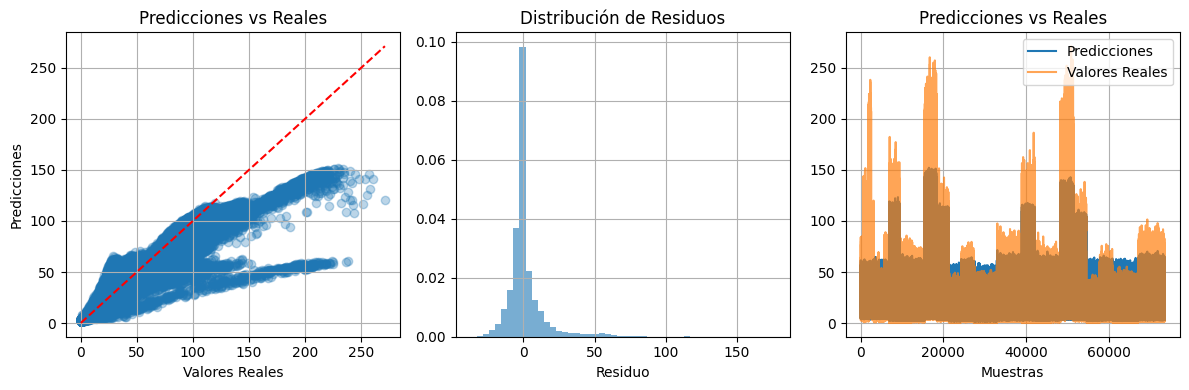

In [21]:
global_model.load_state_dict(torch.load(best_federated_model_path))
global_model.eval()
with torch.no_grad():
    y_pred = global_model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    print("\n=== Evaluación Final del Mejor Modelo Federado ===")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R2: {r2:.4f}")

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Predicciones vs Reales')
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)

plt.subplot(132)
residuals = y_test_np - y_pred
plt.hist(residuals, bins=50, density=True, alpha=0.6)
plt.title('Distribución de Residuos')
plt.xlabel('Residuo')
plt.grid(True)

plt.subplot(133)
plt.plot(y_pred, label="Predicciones")
plt.plot(y_test_np, label="Valores Reales", alpha=0.7)
plt.title('Predicciones vs Reales')
plt.xlabel('Muestras')
plt.legend() 
plt.grid(True)
plt.tight_layout()
plt.show()